IMPORT PACKAGES AND LIBRARIES

In [ ]:
# Import packages and libraries

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import EMNIST
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import KFold
import random
import time
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



DATASET LOADED AND SPLITTED INTO TRAINING AND TESTING DATASET

In [ ]:
# Load datasets
train_set = torchvision.datasets.EMNIST(root='./data/EMNIST', split='balanced', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
test_set = torchvision.datasets.EMNIST(root='./data/EMNIST', split='balanced', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)


trainloader = DataLoader(train_set, batch_size = 64, shuffle = True)
testloader = DataLoader(test_set, batch_size = 64, shuffle = True)


train_subset = torch.utils.data.dataset.Subset(train_set, range(len(train_set)))
test_subset = torch.utils.data.dataset.Subset(test_set, range(len(test_set)))

X_train, y_train = train_subset.dataset.data, train_subset.dataset.targets
X_test, y_test = test_subset.dataset.data, test_subset.dataset.targets




100%|██████████| 561753746/561753746 [00:07<00:00, 75665571.97it/s]


Extracting ./data/EMNIST/EMNIST/raw/gzip.zip to ./data/EMNIST/EMNIST/raw


NUMBER OF TRAINING/TESTING SAMPLES IN DATASET

In [ ]:
# Print number of training and testing datasets
print("Number of training samples: ", len(train_set))
print("Number of testing samples: ", len(test_set))

Number of training samples:  112800
Number of testing samples:  18800


VISUALIZE THE DATASET

Sample 1
True Label: 100 d
-----------------------
Sample 2
True Label: 86 V
-----------------------
Sample 3
True Label: 84 T
-----------------------
Sample 4
True Label: 49 1
-----------------------
Sample 5
True Label: 72 H
-----------------------
Sample 6
True Label: 116 t
-----------------------


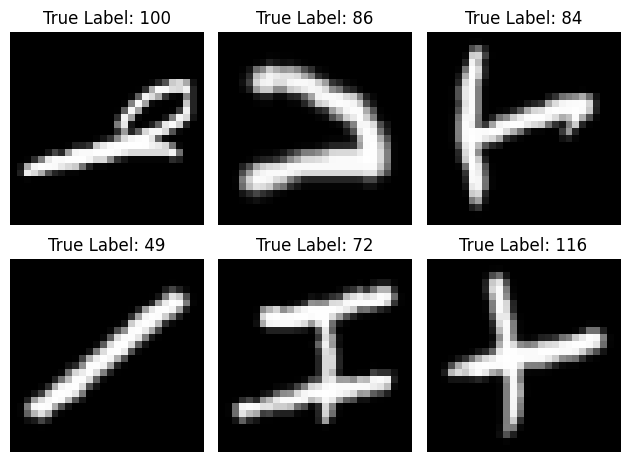

In [ ]:

# Set the random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load the mapping dataset from a text file
mapping_file = "emnist-balanced-mapping.txt"
mapping_dict = {}
with open(mapping_file, "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        index = int(parts[0])
        label = parts[1]
        mapping_dict[index] = label

# Print the true labels of the top six samples in the training dataset
for i, (inputs, labels) in enumerate(trainloader, 1):
    if i > 6:
        break
    print('Sample', i)
    print('True Label:', mapping_dict[labels[0].item()], chr(int(mapping_dict[labels[0].item()])))
    print('-----------------------')

    # Plot the image
    plt.subplot(2, 3, i)
    plt.imshow(inputs[0].cpu().squeeze().numpy(), cmap='gray')
    plt.title("True Label: {}".format(mapping_dict[labels[0].item()]))
    plt.axis('off')

# Display the plotted images
plt.tight_layout()
plt.show()


CNN BASELINE MODEL

In [ ]:
# BASELINE MODEL

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)    # Convolutional layer
        self.batch_norm1 = nn.BatchNorm2d(10)   # Batch normalization after conv1
        self.conv2 = nn.Conv2d(10, 20, 3)    # Convolutional layer
        self.batch_norm2 = nn.BatchNorm2d(20)   # Batch normalization after conv2

        self.fc1 = nn.Linear(20 * 10 * 10, 500)    # Fully connected layer
        self.fc2 = nn.Linear(500, 47)    # Fully connected layer with output size 47

    def forward(self, x):
        input_size = x.size(0)
        # in: batch*1*28*28, out: batch*10*24*24(28-5+1)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) #activation function
        # in: batch*10*24*24, out: batch*10*12*12
        x = F.max_pool2d(x, 2, 2)

        # in: batch*10*12*12, out: batch*20*10*10 (12-3+1)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)

        # 20*10*10 = 2000
        x = x.view(input_size, -1)

        # in: batch*2000  out:batch*500
        x = self.fc1(x)
        x = F.relu(x)

        # in:batch*500 out:batch*47
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Use log softmax along dim=1 for multi-class classification

# Instantiate the CNN model
model = CNN().to(device)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

# Define the hyperparameters as lists
learning_rate = [0.001]
activation = ['relu']
weight_decay = [0.001]  # L2 regularization
dropout_rate = [0.5]  # Dropout
num_hidden_layers = [3]  # Number of hidden layers
num_hidden_neurons = [100]  # Number of hidden neurons in each hidden layer

# Define the optimizer and loss function
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

# Print the model architecture
print(model)

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'

# Perform k-fold cross-validation on the training set
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=1234)  # Initialize k-fold cross-validator
best_train_accuracy = 0.0
best_hyperparameters = None
losses = []
accuracies = []

# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)

for lr in learning_rate:
    for act in activation:
        for wd in weight_decay:
            for dr in dropout_rate:
                for nl in num_hidden_layers:
                    for nn in num_hidden_neurons:

                        # Initialize lists to store per-fold training accuracies
                        fold_train_accuracies = []

                        # Perform k-fold cross-validation
                        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):  # Use shuffled indices instead of trainloader.dataset
                            print("Fold ", fold_idx + 1)

                            start_time = time.time()  # Record the start time

                            # Train the model
                            for epoch in range(10):  # Train for 10 epochs
                                model.train()
                                for i, (inputs, labels) in enumerate(trainloader):
                                    inputs, labels = inputs.to(device), labels.to(device)
                                    optimizer.zero_grad()
                                    outputs = model(inputs)
                                    loss = criterion(outputs, labels)
                                    loss.backward()
                                    optimizer.step()
                                    losses.append(loss.item())
                                model.eval()
                                correct = 0
                                total = 0
                                with torch.no_grad():
                                    for data in trainloader:
                                        images, labels = data
                                        images, labels = images.to(device), labels.to(device)
                                        outputs = model(images)
                                        _, predicted = outputs.max(1)
                                        total += labels.size(0)
                                        correct += predicted.eq(labels).sum().item()
                                accuracy = 100 * correct / total
                                fold_train_accuracies.append(accuracy)
                                accuracies.append(accuracy)

                            end_time = time.time()  # Record the end time
                            training_time = end_time - start_time  # Calculate the training time
                            print('Training time for fold', fold_idx + 1, ':', training_time / 3600, 'hours')


                        # Calculate average training accuracy for this set of hyperparameters
                        avg_train_accuracy = np.mean(fold_train_accuracies)

                        # Update the best hyperparameters if the current set of hyperparameters has higher training accuracy
                        if avg_train_accuracy > best_train_accuracy:
                            best_train_accuracy = avg_train_accuracy
                            best_hyperparameters = {'learning_rate': lr, 'activation': act, 'weight_decay': wd, 'dropout_rate': dr, 'hidden_layers': nl, 'hidden_neurons': nn, 'optimizer': optimizer}



                            # Save the trained model parameters
                            torch.save(model.state_dict(), 'model_state_dict.pt')

print('Best hyperparameters:', best_hyperparameters)
print('Best training accuracy:', best_train_accuracy)


CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=47, bias=True)
)
Fold  1
Training time for fold 1 : 0.47093703938855064 hours
Fold  2
Training time for fold 2 : 0.5615421046813329 hours
Fold  3
Training time for fold 3 : 0.5420829296112061 hours
Best hyperparameters: {'learning_rate': 0.001, 'activation': 'relu', 'weight_decay': 0.001, 'dropout_rate': 0.5, 'hidden_layers': 3, 'hidden_neurons': 100, 'optimizer': RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)}
Best trai

EXPLORING 3 DIFFERENT OPTIMIZERS FOR THE CNN MODEL

In [ ]:
# EXPLORING 3 DIFFERENT OPTIMIZERS(ADAM, SGD $ RMSPROP)

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)    # Convolutional layer
        self.batch_norm1 = nn.BatchNorm2d(10)   # Batch normalization after conv1
        self.conv2 = nn.Conv2d(10, 20, 3)    # Convolutional layer
        self.batch_norm2 = nn.BatchNorm2d(20)   # Batch normalization after conv2

        self.fc1 = nn.Linear(20 * 10 * 10, 500)    # Fully connected layer
        self.fc2 = nn.Linear(500, 47)    # Fully connected layer with output size 47

    def forward(self, x):
        input_size = x.size(0)
        # in: batch*1*28*28, out: batch*10*24*24(28-5+1)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) #activation function
        # in: batch*10*24*24, out: batch*10*12*12
        x = F.max_pool2d(x, 2, 2)

        # in: batch*10*12*12, out: batch*20*10*10 (12-3+1)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)

        # 20*10*10 = 2000
        x = x.view(input_size, -1)

        # in: batch*2000  out:batch*500
        x = self.fc1(x)
        x = F.relu(x)

        # in:batch*500 out:batch*47
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Use log softmax along dim=1 for multi-class classification

# Instantiate the CNN model
model = CNN().to(device)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

criterion = nn.CrossEntropyLoss()

import torch
import torch.optim as optim
from sklearn.model_selection import KFold

# Define the Hyperparameters
Hyperparameters = {
    'optimizer': [optim.SGD, optim.RMSprop, optim.Adam]
}

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'


# Perform k-fold cross-validation on the training set
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=1234)  # Initialize k-fold cross-validator
best_train_accuracy = 0.0
best_hyperparameters = None
losses = []
accuracies = []

# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)

for optimizer_class in Hyperparameters['optimizer']:
    # Initialize lists to store per-fold training accuracies
    fold_train_accuracies = []


    # Perform k-fold cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):  # Use shuffled indices instead of trainloader.dataset
        print("Fold ", fold_idx + 1)

        start_time = time.time()  # Record the start time

        # Train the model
        for epoch in range(10):  # Train for 10 epochs
            model.train()
            optimizer = optimizer_class(model.parameters(), lr=0.001)  # Create optimizer instance
            for i, (inputs, labels) in enumerate(trainloader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data in trainloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    accuracy = 100 * correct / total
                    fold_train_accuracies.append(accuracy)
                    accuracies.append(accuracy)

                end_time = time.time()  # Record the end time
                training_time = end_time - start_time  # Calculate the training time


            # Calculate average training accuracy for this set of hyperparameters
            avg_train_accuracy = np.mean(fold_train_accuracies)

            # Update the best hyperparameters if the current set of hyperparameters has higher training accuracy
            if avg_train_accuracy > best_train_accuracy:
                best_train_accuracy = avg_train_accuracy
                best_hyperparameters = {'optimizer': optimizer_class}


                # Save the trained model parameters
                torch.save(model.state_dict(), 'model_state_dict.pt')

print('Best hyperparameters:', best_hyperparameters)
print('Best training accuracy:', best_train_accuracy)

# Calculate the total training time for all folds
total_training_time = time.time() - start_time
print('Total training time for all folds:', total_training_time, 'seconds')


Fold  1
Fold  2
Fold  3
Fold  1
Fold  2
Fold  3
Fold  1
Fold  2
Fold  3
Best hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>}
Best training accuracy: 99.31780613767178
Total training time for all folds: 363.7759554386139 seconds


EXPLORING 3 DIFFERENT ACTIVATION FUNCTION FOR THE CNN MODEL

In [ ]:
# EXPLORING 3 DIFFERENT ACTIVATION FUNCTIONS

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self, activation):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)    # Convolutional layer
        self.batch_norm1 = nn.BatchNorm2d(10)   # Batch normalization after conv1
        self.conv2 = nn.Conv2d(10, 20, 3)    # Convolutional layer
        self.batch_norm2 = nn.BatchNorm2d(20)   # Batch normalization after conv2

        self.fc1 = nn.Linear(20 * 10 * 10, 500)    # Fully connected layer
        self.fc2 = nn.Linear(500, 47)    # Fully connected layer with output size 47

        self.activation = activation

    def forward(self, x):
        input_size = x.size(0)
        # in: batch*1*28*28, out: batch*10*24*24(28-5+1)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'elu':
            x = F.elu(x)
        elif self.activation == 'leakyrelu':
            x = F.leaky_relu(x)
        # in: batch*10*24*24, out: batch*10*12*12
        x = F.max_pool2d(x, 2, 2)

        # in: batch*10*12*12, out: batch*20*10*10 (12-3+1)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'elu':
            x = F.elu(x)
        elif self.activation == 'leakyrelu':
            x = F.leaky_relu(x)

        # 20*10*10 = 2000
        x = x.view(input_size, -1)

        # in: batch*2000  out:batch*500
        x = self.fc1(x)
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'elu':
            x = F.elu(x)
        elif self.activation == 'leakyrelu':
            x = F.leaky_relu(x)

        # in:batch*500 out:batch*47
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Use log softmax along dim=1 for multi-class classification


# Set random seed for NumPy
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

# Define the hyperparameters as list
activation = ['relu', 'ELU', 'LeakyReLU']
models = []

# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'

# Perform k-fold cross-validation on the training set
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=1234)  # Initialize k-fold cross-validator
best_train_accuracy = 0.0
best_activation = None
losses = []
accuracies = []
lr=0.001
# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)

for activation in activation:
    model = CNN(activation).to(device)  # Instantiate the model with the current activation function
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Pass the learning rate to the optimizer

    # Initialize lists to store per-fold training accuracies
    fold_train_accuracies = []

    # Perform k-fold cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
        print("Fold ", fold_idx + 1)

        start_time = time.time()  # Record the start time

        for epoch in range(10):  # Train for 10 epochs
            model.train()
            for i, (inputs, labels) in enumerate(trainloader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data in trainloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    accuracy = 100 * correct / total
                    fold_train_accuracies.append(accuracy)
                    accuracies.append(accuracy)

            end_time = time.time()  # Record the end time
            training_time = end_time - start_time  # Calculate the training time

        # Calculate average training accuracy for this set of hyperparameters
        avg_train_accuracy = np.mean(fold_train_accuracies)

        # Update the best hyperparameters if current accuracy is better
        if avg_train_accuracy > best_train_accuracy:
            best_train_accuracy = avg_train_accuracy
            best_activation = {'activation': activation}

    # Print the overall best training accuracy and activation function
    print("Best training accuracy:", best_train_accuracy)
    print("Best activation function:", best_activation)

    # Calculate the total training time for all folds
    training_time = time.time() - start_time
    print('Total training time for all folds:', training_time, 'seconds')


Fold  1
Fold  2
Fold  3
Best training accuracy: 96.33710607406836
Best activation function: {'activation': 'relu'}
Total training time for all folds: 383.06835985183716 seconds
Fold  1
Fold  2
Fold  3
Best training accuracy: 96.33710607406836
Best activation function: {'activation': 'relu'}
Total training time for all folds: 377.85214400291443 seconds
Fold  1
Fold  2
Fold  3
Best training accuracy: 96.33710607406836
Best activation function: {'activation': 'relu'}
Total training time for all folds: 377.55394530296326 seconds


EXPLORING LEARNING RATE AND BATCH NORMALISATION FOR THE CNN MODEL

In [ ]:
#exploring learning rate scheduler abd batch normalisation

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN(nn.Module):
    def __init__(self, use_batch_norm):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)    # Convolutional layer
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(10)   # Batch normalization after conv1
        self.conv2 = nn.Conv2d(10, 20, 3)    # Convolutional layer
        if use_batch_norm:
            self.batch_norm2 = nn.BatchNorm2d(20)   # Batch normalization after conv2

        self.fc1 = nn.Linear(20 * 10 * 10, 500)    # Fully connected layer
        self.fc2 = nn.Linear(500, 47)    # Fully connected layer with output size 47

    def forward(self, x):
        input_size = x.size(0)
        # in: batch*1*28*28, out: batch*10*24*24(28-5+1)
        x = self.conv1(x)
        if hasattr(self, 'batch_norm1'):
            x = self.batch_norm1(x)
        x = F.relu(x) #activation function
        # in: batch*10*24*24, out: batch*10*12*12
        x = F.max_pool2d(x, 2, 2)

        # in: batch*10*12*12, out: batch*20*10*10 (12-3+1)
        x = self.conv2(x)
        if hasattr(self, 'batch_norm2'):
            x = self.batch_norm2(x)
        x = F.relu(x)

        # 20*10*10 = 2000
        x = x.view(input_size, -1)

        # in: batch*2000  out:batch*500
        x = self.fc1(x)
        x = F.relu(x)

        # in:batch*500 out:batch*47
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Use log softmax along dim=1 for multi-class classification

# Instantiate the CNN model without batch normalization
model_no_bn = CNN(use_batch_norm=False).to(device)

# Instantiate the CNN model with batch normalization
model_with_bn = CNN(use_batch_norm=True).to(device)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

import torch.optim as optim
from sklearn.model_selection import KFold

# Define the Hyperparameters
Hyperparameters = {
    'learning_rate_scheduler': ['step_lr', 'multi_step_lr'],
    'use_batch_norm': [True, False]  # Include batch normalization as a hyperparameter
}


# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'

# Perform k-fold cross-validation on the training set

k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=1234)  # Initialize KFold
lr = 0.01
losses = []
accuracies = []

# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)

import torch
import torch.nn as nn
import torch.optim as optim
import time

import torch
import torch.nn as nn
import torch.optim as optim
import time

# Initialize best hyperparameters and best training accuracy
best_train_accuracy = 0
best_hyperparameters = {}

# Loop over the hyperparameters to perform grid search
for learning_rate_scheduler in Hyperparameters['learning_rate_scheduler']:
    for use_batch_norm in Hyperparameters['use_batch_norm']:

        # Initialize lists to store per-fold training accuracies
        fold_train_accuracies = []

        # Loop over the folds
        for fold, (train_index, val_index) in enumerate(kf.split(indices)):
            print("Fold ", fold + 1)

            # Instantiate the CNN model with or without batch normalization based on hyperparameter
            if use_batch_norm:
                model = CNN(use_batch_norm=True).to(device)
            else:
                model = CNN(use_batch_norm=False).to(device)

            # Define the loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            if learning_rate_scheduler == 'step_lr':
                optimizer = optim.SGD(model.parameters(), lr=lr)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            elif learning_rate_scheduler == 'multi_step_lr':
                optimizer = optim.SGD(model.parameters(), lr=lr)
                milestones = [2, 5, 10] # epochs at which to change the learning rate
                scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
            else:
                raise ValueError("Invalid learning rate scheduler. Choose from 'step_lr' or 'multi_step_lr'.")

            # Train the model
            start_time = time.time()  # Record the start time

            for epoch in range(10):  # Train for 10 epochs
                model.train()
                for i, (inputs, labels) in enumerate(trainloader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.item())
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in trainloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()
                        accuracy = 100 * correct / total
                        fold_train_accuracies.append(accuracy)
                        accuracies.append(accuracy)

            end_time = time.time()  # Record the end time
            training_time = end_time - start_time  # Calculate the training time
            print('Training time for fold', fold + 1, ':', training_time / 3600, 'hours')

        # Calculate average training accuracy for this set of hyperparameters
        avg_train_accuracy = sum(fold_train_accuracies) / len(fold_train_accuracies)

        # Update the best hyperparameters if current accuracy is better
        if avg_train_accuracy > best_train_accuracy:
            best_train_accuracy = avg_train_accuracy
            best_hyperparameters = {'Learning Rate Scheduler': learning_rate_scheduler, 'use_batch_norm': use_batch_norm }

    # Save the trained model parameters
    torch.save(model.state_dict(), 'model_state_dict.pt')

# Print the best hyperparameters and accuracy
print('Model hyperparameters:', best_hyperparameters)
print('Best training accuracy:', best_train_accuracy)


Fold  1
Training time for fold 1 : 0.102000822491116 hours
Fold  2
Training time for fold 2 : 0.10198936184247334 hours
Fold  3
Training time for fold 3 : 0.10211088630888197 hours
Fold  1
Training time for fold 1 : 0.10109536084863875 hours
Fold  2
Training time for fold 2 : 0.09962782581647237 hours
Fold  3
Training time for fold 3 : 0.09900369432237413 hours
Fold  1
Training time for fold 1 : 0.09870998117658827 hours
Fold  2
Training time for fold 2 : 0.09897399577829573 hours
Fold  3
Training time for fold 3 : 0.099231658577919 hours
Fold  1
Training time for fold 1 : 0.0961602144771152 hours
Fold  2
Training time for fold 2 : 0.09702472084098392 hours
Fold  3
Training time for fold 3 : 0.09659377137819926 hours
Model hyperparameters: {'Learning Rate Scheduler': 'multi_step_lr', 'use_batch_norm': True}
Best training accuracy: 86.78280006052606


INCOPORATING THE BEST OF THE HYPERPARAMETERS INTO THE CNN MODEL

In [ ]:
# INCOPORATING THE BEST OF THE HYPERPARAMETERS INTO THE MODEL

""" Final Model: After Several tuning using kfold cross validation, the best hyperparameters that gave the best training accuracy
are: hidden_neurons(100), hidden_layers(3),Optimizer(ADAM),activation function(RELU), weight_decay(0.001),learning rate(0.001) and dropout(0.2)."""

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)    # Convolutional layer
        self.batch_norm1 = nn.BatchNorm2d(10)   # Batch normalization after conv1
        self.conv2 = nn.Conv2d(10, 20, 3)    # Convolutional layer
        self.batch_norm2 = nn.BatchNorm2d(20)   # Batch normalization after conv2

        self.fc1 = nn.Linear(20 * 10 * 10, 500)    # Fully connected layer
        self.fc2 = nn.Linear(500, 47)    # Fully connected layer with output size 47

    def forward(self, x):
        input_size = x.size(0)
        # in: batch*1*28*28, out: batch*10*24*24(28-5+1)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) #activation function
        # in: batch*10*24*24, out: batch*10*12*12
        x = F.max_pool2d(x, 2, 2)

        # in: batch*10*12*12, out: batch*20*10*10 (12-3+1)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)

        # 20*10*10 = 2000
        x = x.view(input_size, -1)

        # in: batch*2000  out:batch*500
        x = self.fc1(x)
        x = F.relu(x)

        # in:batch*500 out:batch*47
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # log softmax along dim=1 for multi-class classification

# Instantiate the CNN model
model = CNN().to(device)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

# Define the hyperparameters as lists
learning_rate = [0.001]
activation = ['relu']
weight_decay = [0.001]  # L2 regularization
dropout_rate = [0.2]  # Dropout
num_hidden_layers = [3]  # Number of hidden layers
num_hidden_neurons = [100]  # Number of hidden neurons in each hidden layer

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'

best_train_accuracy = 0.0
best_hyperparameters = None
losses = []
accuracies = []

start_time = time.time()  # Record the start time

import numpy as np
import torch
import time

# Shuffle the data
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)
for lr in learning_rate:
    for act in activation:
        for wd in weight_decay:
            for dr in dropout_rate:
                for nl in num_hidden_layers:
                    for nn in num_hidden_neurons:

                        # Train the model
                        for epoch in range(10):  # Train for 10 epochs
                            model.train()
                            epoch_loss = 0
                            for i, (inputs, labels) in enumerate(trainloader):
                                inputs, labels = inputs.to(device), labels.to(device)
                                optimizer.zero_grad()
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                                loss.backward()
                                optimizer.step()
                                epoch_loss += loss.item()
                            train_loss = np.mean(epoch_loss / len(trainloader))
                            losses.append(loss.item())

                            model.eval()
                            correct = 0
                            total = 0
                            with torch.no_grad():
                                for data in trainloader:
                                    images, labels = data
                                    images, labels = images.to(device), labels.to(device)
                                    outputs = model(images)
                                    _, predicted = outputs.max(1)
                                    total += labels.size(0)
                                    correct += predicted.eq(labels).sum().item()
                            accuracy = 100 * correct / total
                            accuracies.append(accuracy)
                            avg_train_accuracy = np.mean(accuracy)

                        end_time = time.time()  # Record the end time
                        training_time = end_time - start_time  # Calculate the training time

                    # Update the best hyperparameters if the current set of hyperparameters has higher training accuracy
                    if avg_train_accuracy > best_train_accuracy:
                        best_train_accuracy = avg_train_accuracy
                        best_hyperparameters = (lr, act, wd, nl, nn)

                        # Save the trained model parameters
                        torch.save(model.state_dict(), 'model_state_dict.pt')

#print('Best hyperparameters:', best_hyperparameters)
print('Training accuracy:', best_train_accuracy)
# Print the best hyperparameters and accuracy
print('Model hyperparameters:', best_hyperparameters)


Training accuracy: 95.78280141843972
Model hyperparameters: (0.001, 'relu', 0.001, 3, 100)


LOSS & ACCURACY VS EPOCH GRAPH FOR THE CNN MODEL

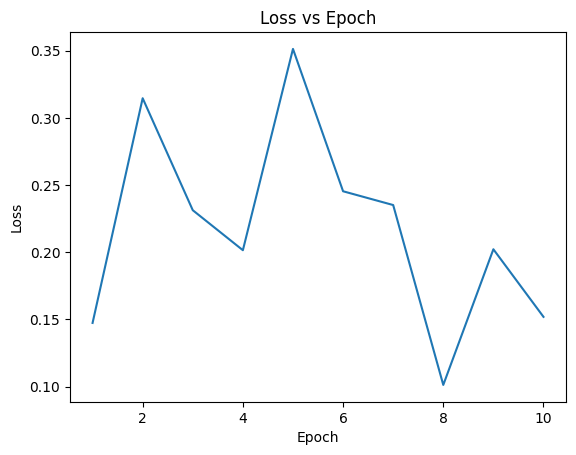

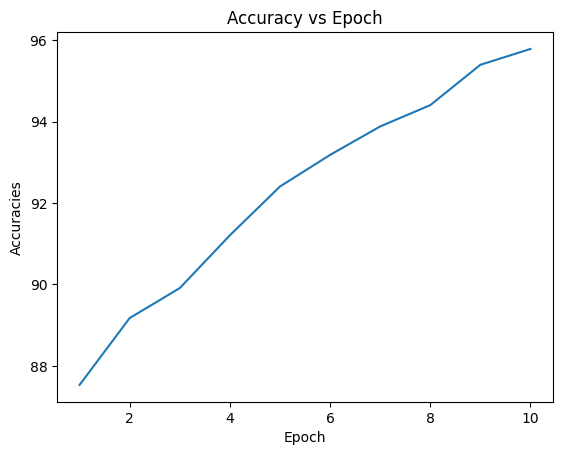

In [ ]:

# Print the loss vs epoch graph
#for epoch, loss in enumerate(losses):
    #print(f'Epoch {epoch + 1}, Loss: {losses}')

# Plot the loss vs epoch graph
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()


# Plot the accuracy vs epoch graph

plt.plot(range(1, len(accuracies) + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Accuracy vs Epoch')
plt.show()

MLP BASELINE MODEL

In [ ]:

#Baseline MLP Model

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons, activation, dropout):
        super().__init__()
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_neurons))
            else:
                layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            if activation == 'LeakyReLU':
                layers.append(nn.LeakyReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


train_losses = []  # list to store training losses
train_accs = []  # list to store training accuracies

# Record the start time
start_time = time.time()

def train_and_evaluate_model(mlp, criterion, optimizer, train_loader):
    """
    Train and evaluate the model for a fixed number of epochs on the given train loader
    """
    for epoch in range(20):
        epoch_loss = 0
        for X_batch, y_batch in trainloader:
            batch_size = X_batch.shape[0]
            X_batch = X_batch.view(batch_size, -1)
            optimizer.zero_grad()
            output = mlp(X_batch.to(device))
            loss = criterion(output, y_batch.to(torch.long).to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

            # Append the loss to the list
            train_losses.append(loss.item())

        # Store training loss for the epoch
        epoch_avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses_per_epoch.append(epoch_avg_loss)  # Append the average loss per epoch to a separate list

        # Evaluate the model on the training set
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in trainloader:
                batch_size = X_batch.shape[0]
                X_batch = X_batch.view(batch_size, -1)
                output = mlp(X_batch.to(device))
                _, predicted = torch.max(output, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.to(device)).sum().item()
            train_acc = 100 * correct / total
            # Append the accuracy to the list
            train_accs.append(train_acc)

    return train_acc


# Define the hyperparameters for the grid search
params = {'hidden_layers': [4], 'hidden_neurons': [128], 'activation': ['LeakyReLU'], 'dropout': [0.2], 'learning_rate': [0.01], 'optimizer': [optim.SGD]}

# Define the file path to save the model parameters
best_model_path = 'best_model_params.pt'

from sklearn.model_selection import KFold

# Initialize k-fold cross-validation
num_folds = 3
kfold = KFold(n_splits=num_folds)

# Initialize lists to store training accuracy and average loss per epoch
best_train_acc = 0
best_params = {}

# Initialize fold_train_accs and train_losses_per_epoch outside the loop for hyperparameters
fold_train_accs = []
train_losses_per_epoch = []

# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)

# Loop over each fold
for fold_idx, (train_indices, _) in enumerate(kfold.split(indices)):

    # Loop through the hyperparameters and perform k-fold cross-validation for each set of hyperparameters
    best_train_acc = 0
    best_acc = 0
    best_params = {}
    for hidden_layers in params['hidden_layers']:
        for hidden_neurons in params['hidden_neurons']:
            for activation in params['activation']:
                for dropout in params['dropout']:
                    for learning_rate in params['learning_rate']:
                        for optimizer in params['optimizer']:
                            # Initialize lists to store the train accuracies for each fold
                            fold_train_accs = []
                            for fold, (train_index, _) in enumerate(kfold.split(indices)):
                                # Get the train data for this fold using the shuffled indices
                                train_data = [trainloader.dataset[i] for i in train_index]
                                # Define the model and optimizer with the current set of hyperparameters
                                mlp = MLP(input_size=784, output_size=47, hidden_layers=hidden_layers, hidden_neurons=hidden_neurons, activation=activation, dropout=dropout)
                                mlp.to(device)
                                criterion = nn.CrossEntropyLoss()
                                optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

                                # Train and evaluate the model on the current fold
                                train_acc = train_and_evaluate_model(mlp, criterion, optimizer, trainloader)
                                fold_train_accs.append(train_acc)

                                end_time = time.time()  # Record the end time
                                training_time = end_time - start_time  # Calculate the training time
                                print('Training time for fold', fold_idx + 1, ':', training_time / 3600, 'hours')

                            # Calculate average training accuracy for the current set of hyperparameters
                            avg_train_acc = np.mean(fold_train_accs)

                            # Update the best hyperparameters and accuracy if the current set of hyperparameters is better
                            if avg_train_acc > best_train_acc:
                                best_train_acc = avg_train_acc
                                best_acc = avg_train_acc  # update best overall accuracy to the best average training accuracy
                                best_params = {'hidden_layers': hidden_layers, 'hidden_neurons': hidden_neurons, 'activation': activation, 'dropout': dropout, 'learning_rate': learning_rate, 'optimizer': optimizer}

                                # Save the trained model parameters
                                torch.save(mlp.state_dict(), 'best_model_params.pt')


# Print the best hyperparameters and accuracy
print('Model hyperparameters:', best_params)
print('Best training accuracy:', best_acc)


Training time for fold 1 : 0.09821467889679802 hours
Training time for fold 1 : 0.20113665137026046 hours
Training time for fold 1 : 0.3028806695010927 hours
Training time for fold 2 : 0.40686758352650537 hours
Training time for fold 2 : 0.5098297535710865 hours
Training time for fold 2 : 0.6152967077493667 hours
Training time for fold 3 : 0.7206596794393327 hours
Training time for fold 3 : 0.8259531711207496 hours
Training time for fold 3 : 0.9335823449823591 hours
Model hyperparameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'activation': 'LeakyReLU', 'dropout': 0.2, 'learning_rate': 0.01, 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)}
Best training accuracy: 60.52689125295509


EXPLORING 3 DIFFERENT ACTIVATION FUNCTIONS FOR THE MLP MODEL

In [ ]:
# EXPLORING 3 DIFFRENT ACTIVATION FUNCTIONS


# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the MLP model with flatten layer
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons, activation, dropout):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_neurons))
            else:
                layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            if activation == 'ELU':
                layers.append(nn.ELU())
            elif activation == 'ReLU':
                layers.append(nn.ReLU())
            elif activation == 'LeakyReLU':
                layers.append(nn.LeakyReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


train_losses = []  # list to store training losses
train_accs = []  # list to store training accuracies

start_time = time.time()  # Record the start time

def train_and_evaluate_model(mlp, criterion, optimizer, train_loader):
    """
    Train and evaluate the model for a fixed number of epochs on the given train loader
    """
    for epoch in range(20):
        epoch_loss = 0
        for X_batch, y_batch in trainloader:
            batch_size = X_batch.shape[0]
            X_batch = X_batch.view(batch_size, -1)
            optimizer.zero_grad()
            output = mlp(X_batch.to(device))
            # Update the target shape and type
            target = y_batch.to(torch.long).to(device)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

            # Append the loss to the list
            train_losses.append(loss.item())

        # Store training loss for the epoch
        train_losses.append(epoch_loss / len(train_loader.dataset))

        # Evaluate the model on the training set
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in trainloader:
                batch_size = X_batch.shape[0]
                X_batch = X_batch.view(batch_size, -1)
                output = mlp(X_batch.to(device))
                _, predicted = torch.max(output, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.to(device)).sum().item()
            train_acc = 100 * correct / total
            # Append the accuracy to the list
            train_accs.append(train_acc)

    return train_acc

# Define the grid search parameters
param_grid = {
    'activation': ['ReLU', 'ELU', 'LeakyReLU']
}


from sklearn.model_selection import KFold

# Initialize k-fold cross-validation
num_folds = 3
kfold = KFold(n_splits=num_folds)

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'


# Shuffle the data once before starting k-fold cross validation
indices = np.arange(len(trainloader.dataset))
np.random.shuffle(indices)


# Loop over each fold
for fold_idx, (train_indices, _) in enumerate(kfold.split(indices)):

    # Loop through the hyperparameters and train and evaluate the model for each set of hyperparameters
    best_train_acc = 0
    best_acc = 0
    best_params = {}
    for activation in param_grid['activation']:
        # Initialize lists to store the train accuracies for each fold
        fold_train_accs = []
        for fold, (train_index, _) in enumerate(kfold.split(indices)):
            # Define the model and optimizer with the current set of hyperparameters
            mlp = MLP(input_size=784, output_size=47, hidden_layers=hidden_layers, hidden_neurons=hidden_neurons, activation=activation, dropout=dropout)
            mlp.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

            # Train and evaluate the model on the current fold
            train_acc = train_and_evaluate_model(mlp, criterion, optimizer, trainloader)
            fold_train_accs.append(train_acc)

        end_time = time.time()  # Record the end time
        training_time = end_time - start_time  # Calculate the training time
        print('Training time for fold', fold_idx + 1, ':', training_time / 3600, 'hours')

    # Calculate average training accuracy for the current set of hyperparameters
    avg_train_acc = np.mean(fold_train_accs)

    # Update the best hyperparameters and accuracy if the current set of hyperparameters is better
    if avg_train_acc > best_train_acc:
        best_train_acc = avg_train_acc
        best_acc = avg_train_acc  # update best overall accuracy to the best average training accuracy
        best_params = {'activation': activation}

        # Save the trained model parameters
        torch.save(mlp.state_dict(), 'best_model_params.pt')

# Print the best hyperparameters and accuracy
print('Model hyperparameters:', best_params)
print('Best training accuracy:', best_acc)



Training time for fold 3 : 0.640176869697041 hours
Training time for fold 3 : 1.2909670156902737 hours
Training time for fold 3 : 1.9313735567861132 hours
Model hyperparameters: {'activation': 'ELU'}
Best training accuracy: 72.57771867612293


MLP FINAL MODEL

In [ ]:
# INCOPORATING THE BEST OF THE HYPERPARAMETERS INTO THE FINAL MODEL

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons, activation, dropout):
        super().__init__()
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_neurons))
            else:
                layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            if activation == 'ELU':
                layers.append(nn.ELU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

train_losses = []  # list to store training losses
train_accs = []  # list to store training accuracies

def train_and_evaluate_model(mlp, criterion, optimizer, train_loader):
    """
    Train and evaluate the model for a fixed number of epochs on the given train loader
    """
    for epoch in range(20):
        epoch_losses = 0
        for X_batch, y_batch in trainloader:
            batch_size = X_batch.shape[0]
            X_batch = X_batch.view(batch_size, -1)
            optimizer.zero_grad()
            output = mlp(X_batch.to(device))
            loss = criterion(output, y_batch.to(device))
            loss.backward()
            optimizer.step()
            epoch_losses += loss.item() * batch_size
        train_loss = np.mean(epoch_losses / len(trainloader))
        train_losses.append(loss.item())

        # Evaluate the model on the training set
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in trainloader:
                batch_size = X_batch.shape[0]
                X_batch = X_batch.view(batch_size, -1)
                output = mlp(X_batch.to(device))
                _, predicted = torch.max(output, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.to(device)).sum().item()
            train_acc = 100 * correct / total
            # Append the accuracy to the list
            train_accs.append(train_acc)

    return train_acc


# Define the hyperparameters for the grid search
params = {'hidden_layers': [3], 'hidden_neurons': [128], 'activation': ['ELU'], 'dropout': [0.2], 'learning_rate': [0.1], 'optimizer': [optim.SGD]}

# Define the file path to save the best model parameters
best_model_path = 'best_model_params.pt'

# Loop through the hyperparameters and train and evaluate the model for each set of hyperparameters
best_train_acc = 0
best_acc = 0
best_params = {}
for hidden_layers in params['hidden_layers']:
    for hidden_neurons in params['hidden_neurons']:
        for activation in params['activation']:
            for dropout in params['dropout']:
                for learning_rate in params['learning_rate']:
                    for optimizer in params['optimizer']:
                        # Define the model and optimizer with the current set of hyperparameters
                        mlp = MLP(input_size=784, output_size=47, hidden_layers=hidden_layers, hidden_neurons=hidden_neurons, activation=activation, dropout=dropout)
                        mlp.to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

                        # Train and evaluate the model
                        train_acc = train_and_evaluate_model(mlp, criterion, optimizer, trainloader)

                        end_time = time.time()  # Record the end time
                        training_time = end_time - start_time  # Calculate the training time


                # Calculate average training accuracy for the current set of hyperparameters
                avg_train_acc = np.mean(train_accs)

                # Update the best hyperparameters and accuracy if the current set of hyperparameters is better
                if avg_train_acc > best_train_acc:
                    best_train_acc = avg_train_acc
                    best_acc = avg_train_acc  # update best overall accuracy to the best average training accuracy
                    best_params = {'hidden_layers': hidden_layers, 'hidden_neurons': hidden_neurons, 'activation': activation, 'dropout': dropout, 'learning_rate': learning_rate, 'optimizer': optimizer}

                    # Save the trained model parameters
                    torch.save(mlp.state_dict(), 'best_model_params.pt')

# Print the best hyperparameters and accuracy
print('Best hyperparameters:', best_params)
print('Best training accuracy:', best_acc)


# Calculate the total training time for all folds
total_training_time = time.time() - start_time
print('Total training time for all folds:', total_training_time, 'seconds')



Best hyperparameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'activation': 'ELU', 'dropout': 0.2, 'learning_rate': 0.1, 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)}
Best training accuracy: 77.32052304964537
Total training time for all folds: 9289.987621545792 seconds


LOSS AND ACCURACY GRAPH WITH RESPECT TO EPOCH FOR THE MLP MODEL

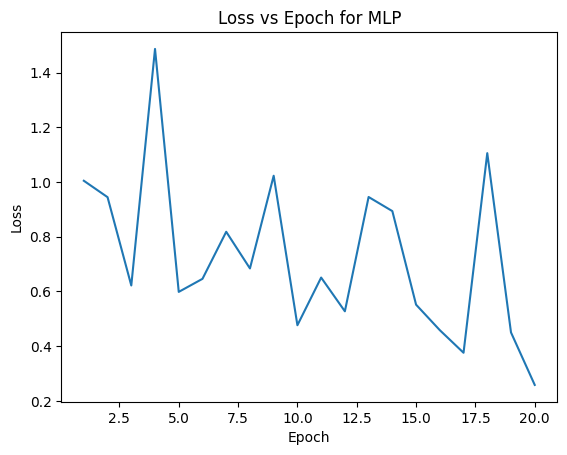

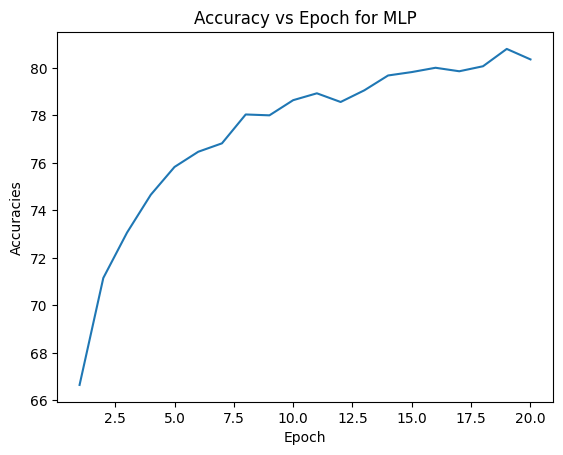

In [ ]:

# Print the loss vs epoch graph
#for epoch, loss in enumerate(train_losses):
    #print(f'Epoch {epoch + 1}, Loss: {train_losses}')

# Plot the loss vs epoch graph
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for MLP')
plt.show()

# Plot the accuracy vs epoch graph

plt.plot(range(1, len(train_accs) + 1), train_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Accuracy vs Epoch for MLP')
plt.show()

EVALUATION OF THE CNN MODEL ON THE TEST DATASET

In [ ]:

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# Load the saved model using the correct file name
model = CNN().to(device)
model.load_state_dict(torch.load('model_state_dict.pt'))

# Set the model to evaluation mode
model.eval()

# Initialize variables to store test accuracy and loss
test_loss = 0.0
test_correct = 0
test_total = 0

# Loop over the testing dataset
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# Calculate average test loss and accuracy
test_loss /= len(testloader)
test_accuracy = 100 * correct / total

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))


Test Loss: 0.5116, Test Accuracy: 94.92%


EVALUATION OF THE MLP MODEL ON THE TEST DATASET

In [ ]:

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# Load the best model from file
mlp = MLP(input_size=784, output_size=47, hidden_layers=best_params['hidden_layers'], hidden_neurons=best_params['hidden_neurons'], activation=best_params['activation'], dropout=best_params['dropout']).to(device)
mlp.load_state_dict(torch.load('best_model_params.pt'))


# Initialize variables to store test accuracy and loss
test_loss = 0.0
test_correct = 0
test_total = 0

# Evaluate the loaded model on the test set
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in testloader:
        batch_size = X_batch.shape[0]
        X_batch = X_batch.view(batch_size, -1)
        output = mlp(X_batch.to(device))
        _, predicted = torch.max(output, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch.to(device)).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_acc = 100 * correct / total


# Calculate average test loss and accuracy
test_loss /= len(testloader)
test_accuracy = 100 * correct / total


print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.3417, Test Accuracy: 78.85%


COMPARISM OF THE CNN PREDICTED LABELS WITH THE TRUE LABELS

Sample 1
Prediction: 85 U
True Label: 85 U
-----------------------
Sample 2
Prediction: 86 V
True Label: 86 V
-----------------------
Sample 3
Prediction: 67 C
True Label: 67 C
-----------------------
Sample 4
Prediction: 90 Z
True Label: 90 Z
-----------------------
Sample 5
Prediction: 71 G
True Label: 71 G
-----------------------
Sample 6
Prediction: 73 I
True Label: 73 I
-----------------------


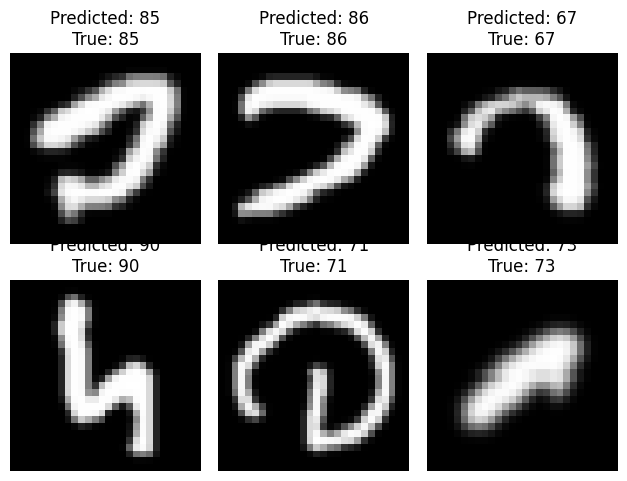

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.cuda.manual_seed(seed)

# Load the mapping dataset from a text file
mapping_file = "emnist-balanced-mapping.txt"
mapping_dict = {}
with open(mapping_file, "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        index = int(parts[0])
        label = parts[1]
        mapping_dict[index] = label

# Load the saved model
model = CNN()
model.load_state_dict(torch.load('model_state_dict.pt'))
model.to(device)

# Print the predictions and true labels of the top six samples in the testing dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(testloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i <= 6:
            print('Sample', i)
            print('Prediction:', mapping_dict[predicted[0].item()], chr(int(mapping_dict[predicted[0].item()])))
            print('True Label:', mapping_dict[labels[0].item()], chr(int(mapping_dict[labels[0].item()])))
            print('-----------------------')

            # Plot the image
            plt.subplot(2, 3, i)
            plt.imshow(inputs[0].cpu().squeeze().numpy(), cmap='gray')
            plt.title("Predicted: {}\nTrue: {}".format(mapping_dict[predicted[0].item()], mapping_dict[labels[0].item()]))
            plt.axis('off')

        if i == 6:
            break

# Display the plotted images
plt.tight_layout()
plt.show()


COMPARISM OF THE MLP PREDICTED LABELS WITH THE TRUE LABELS

Sample 1
Prediction: 116 t
True Label: 116 t
-----------------------
Sample 2
Prediction: 53 5
True Label: 53 5
-----------------------
Sample 3
Prediction: 86 V
True Label: 86 V
-----------------------
Sample 4
Prediction: 76 L
True Label: 76 L
-----------------------
Sample 5
Prediction: 51 3
True Label: 51 3
-----------------------
Sample 6
Prediction: 102 f
True Label: 70 F
-----------------------


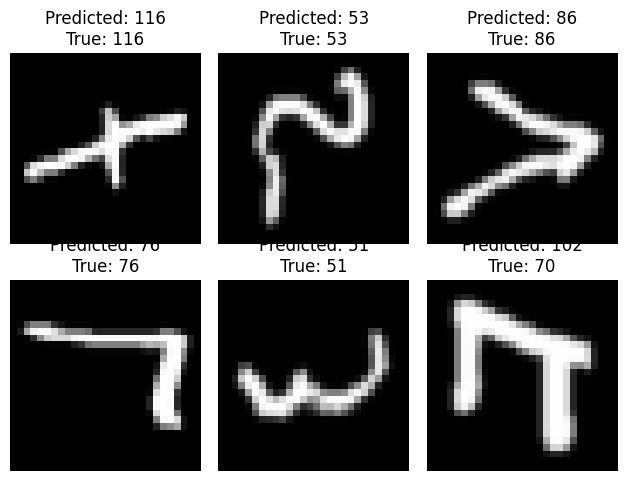

In [ ]:

# Set the random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load the mapping dataset from a text file
mapping_file = "emnist-balanced-mapping.txt"
mapping_dict = {}
with open(mapping_file, "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        index = int(parts[0])
        label = parts[1]
        mapping_dict[index] = label

# Load the saved model
mlp = MLP(input_size=784, output_size=47, hidden_layers=best_params['hidden_layers'], hidden_neurons=best_params['hidden_neurons'], activation=best_params['activation'], dropout=best_params['dropout'])
mlp.load_state_dict(torch.load('best_model_params.pt'))
model.to(device)

# Create lists to store predicted and true labels
predicted_labels = []
true_labels = []

# Print the predictions and true labels of the top six samples in the testing dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(testloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i <= 6:
            print('Sample', i)
            print('Prediction:', mapping_dict[predicted[0].item()], chr(int(mapping_dict[predicted[0].item()])))
            print('True Label:', mapping_dict[labels[0].item()], chr(int(mapping_dict[labels[0].item()])))
            print('-----------------------')

            # Plot the image
            plt.subplot(2, 3, i)
            plt.imshow(inputs[0].cpu().squeeze().numpy(), cmap='gray')
            plt.title("Predicted: {}\nTrue: {}".format(mapping_dict[predicted[0].item()], mapping_dict[labels[0].item()]))
            plt.axis('off')

        if i == 6:
            break

# Display the plotted images
plt.tight_layout()
plt.show()


CNN CONFUSION MATRIX

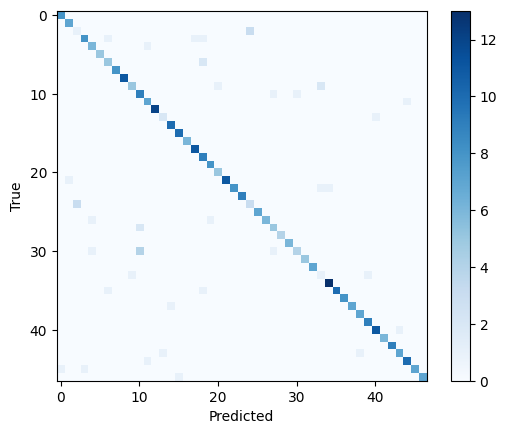

In [ ]:
# Create a confusion matrix

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


MLP CONFUSION MATRIX

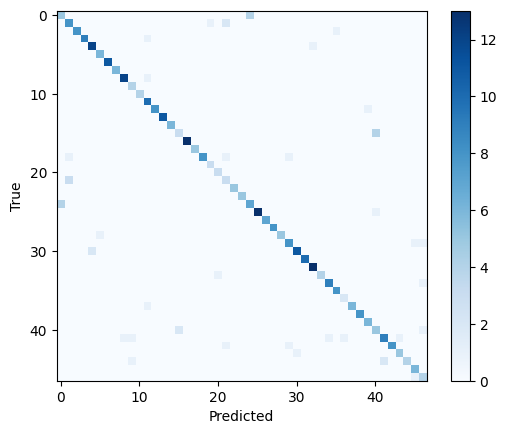

In [ ]:
# Create a confusion matrix

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


CNN SUMMARY: REPORT OF THE ACCURACY, PRECISION, RECALL, AND F1

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load the mapping dataset from a text file
mapping_file = "emnist-balanced-mapping.txt"
mapping_dict = {}
with open(mapping_file, "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        index = int(parts[0])
        label = parts[1]
        mapping_dict[index] = label

# Load the saved model
model = CNN()
model.load_state_dict(torch.load('model_state_dict.pt'))
model.to(device)

# Evaluate the model and calculate true labels and predicted labels
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(testloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(predicted.cpu().numpy().tolist())

        if i == 6:
            break

# Convert the lists to numpy arrays for further calculations
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1_score_val = f1_score(true_labels, predicted_labels, average='weighted')

# Print the performance metrics
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_score_val))


Precision: 0.9139
Recall: 0.9062
F1 Score: 0.9053


MLP SUMMARY: REPORT OF THE ACCURACY, PRECISION, RECALL, AND F1

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load the mapping dataset from a text file
mapping_file = "emnist-balanced-mapping.txt"
mapping_dict = {}
with open(mapping_file, "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        index = int(parts[0])
        label = parts[1]
        mapping_dict[index] = label

# Load the saved model
mlp = MLP(input_size=784, output_size=47, hidden_layers=best_params['hidden_layers'], hidden_neurons=best_params['hidden_neurons'], activation=best_params['activation'], dropout=best_params['dropout'])
mlp.load_state_dict(torch.load('best_model_params.pt'))
model.to(device)

# Evaluate the model and calculate true labels and predicted labels
mlp.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(testloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(predicted.cpu().numpy().tolist())

        if i == 6:
            break

# Convert the lists to numpy arrays for further calculations
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the performance metrics
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_score_val))


Accuracy: 0.8698
Precision: 0.8819
Recall: 0.8698
F1 Score: 0.9053
